In [1]:
import sys
sys.path.append("..")
sys.path.append("../relational-networks")
import torch
import torch.nn
import numpy as np
from model2 import RN
from original_models2 import Model as SAE
from torch.utils.data import DataLoader
from utils import ClevrDataset, preprocess_batch__, PhotoBwDataset


# params
weights_dirs = ["../models/w-r0-k1", "../models/w-r1-k0", "../models/w-r1-k1"]
prob_dir = "/home/sontung/thesis/photorealistic-blocksworld/blocks-5-3-old"
val_dir = "/home/sontung/thesis/photorealistic-blocksworld/blocks-4-3-old"
clevr_dir = "/home/sontung/thesis/clevr/data/CLEVR_v1.0"
nb_epochs = 100
dev = "cuda"

# models and loss
vae = SAE(mode="nocvae")
vae.to("cuda")
vae.eval()

val_loader2 = DataLoader(PhotoBwDataset(),
                         batch_size=1, shuffle=True, pin_memory=False, num_workers=4)

im_real = []
for image in val_loader2:
    image = image.to(dev)
    im_real.append(image)
    break
print(image.size())

read 410 images from photorealistic bw
torch.Size([1, 3, 128, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


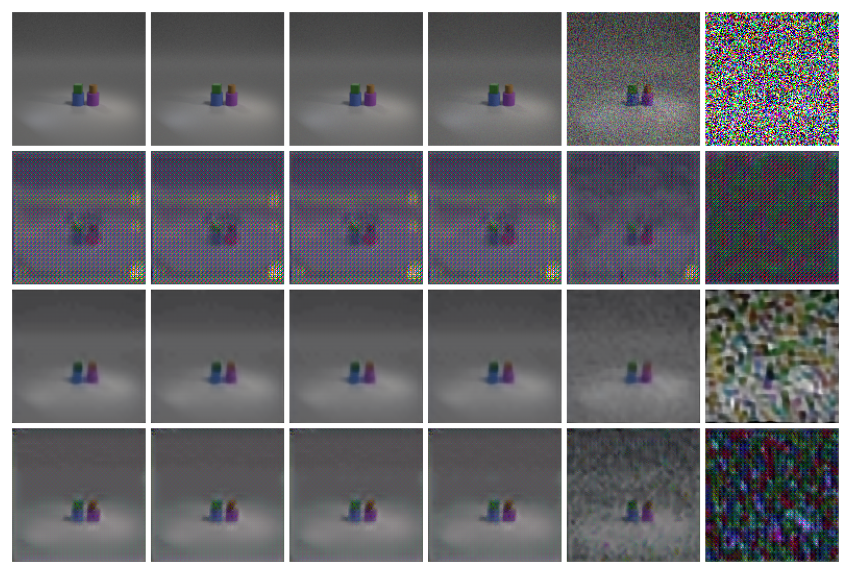

In [2]:
im = []
for noise_w in [0.001, 0.003, 0.005, 0.01, 0.1, 1]:
    res = image + torch.randn((image.size(0), 3, 128, 128)).cuda()*noise_w
    im.append(res)
im = torch.cat(im)
res = [im]
for weights_dir in ["../models/w-r0-k1", "../models/w-r1-k0", "../models/w-r1-k1"]:
    vae.load_state_dict(torch.load(weights_dir, map_location="cuda"))
    res.append(vae(im)[-1])
res = torch.cat(res)
res.size()

from torchvision.utils import make_grid
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
plt.axis("off")
plt.imshow(np.transpose(make_grid(res.detach().cpu(), padding=5, normalize=False, pad_value=50, nrow=6),
                        (1, 2, 0)))

plt.savefig("recon_under_noise.png", transparent=True, bbox_inches='tight')

In [5]:
import numpy as np
import json
import sys
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly

plotly.io.orca.config.executable = '/home/sontung/tools/orca-1.3.1.AppImage'


fig = go.Figure()

names = ["both", "only recon", "only kld"]
colors = [dict(color='firebrick'), dict(color='royalblue'), dict(color='green')]
d1=[66.63904351128473, 67.40167202419705, 68.74479505750868, 74.14376864963107, 157.20625542534722, 189.67924329969617, 195.42846035427516]

d2=[92.62892489963107, 92.75010104709202, 92.95621914333768, 94.31615804036458, 131.64788716634115, 174.2771711561415, 183.42017686631945]

d3=[69.9661614312066, 71.0510498046875, 72.95460578070747, 80.99446784125433, 165.52641805013022, 194.53105129665798, 208.23718736436632]


fig.add_trace(
    go.Scatter(
        x=list(range(6)),
        y=d1,
        mode="lines+markers",
        name="only kld",
        line=colors[2],
    )
)

fig.add_trace(
    go.Scatter(
        x=list(range(6)),
        y=d2,
        mode="lines+markers",
        name="only recon",
        line=colors[1],
    )
)

fig.add_trace(
    go.Scatter(
        x=list(range(6)),
        y=d3,
        mode="lines+markers",
        name="both",
        line=colors[0],
    )
)

fig.update_layout(legend_orientation="h")
fig.update_xaxes(ticks="outside")
fig.update_yaxes(ticks="outside")

fig.update_layout(
    yaxis_title="error",
    xaxis_title="noise magnitude",
    legend=dict(x=0.0, y=-0.25),

    xaxis = dict(
        tickmode = 'array',
        tickvals=list(range(6)),
        ticktext=[str(du) for du in [0.001, 0.003, 0.005, 0.01, 0.1, 1, 10]]
    ),
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#000000"
    ),
    paper_bgcolor='rgba(0,0,0,0)',
    margin=dict(l=80, r=10, t=10, b=80)
#     plot_bgcolor='rgba(0,0,0,0)'
)

fig.show()
fig.write_image("recon-kld-on-m1.png", width=1000, height=None, scale=2)
